## 1\. K-Means 클러스터링의 한계와 극복

  - **문제 상황**: K-Means는 쉽고 빠르지만, 현실 세계의 데이터는 항상 동그랗고 깔끔한 형태로 존재하지 않음.
  - **예시**: 고객 그룹은 `크기`나 `밀도`가 서로 다르거나, 서비스 이용 패턴이 길고 구불구불한 `비 구형(non-globular)` 형태를 띨 수 있음.
  - **한계**: 이러한 데이터에 기본적인 K-Means 알고리즘을 적용하면, 예상과 다른 잘못된 군집 결과를 내놓을 수 있음.

-----

## 2\. 핵심 원리 파헤치기 (Deep Dive)

  - **K-Means의 핵심 원리**: '각 데이터 지점으로부터 군집 중심(centroid)까지의 거리가 가장 가까운 곳에 데이터를 할당'하는 것.
  - **암묵적 가정**: 이 원리 때문에 K-Means는 데이터가 각 군집의 중심을 기준으로 **구형으로 모여 있고**, 군집들의 **크기나 밀도가 비슷할 것**이라고 가정함.
  - **'모둠 짜기 로봇' 비유**: 로봇(K-Means)은 모든 모둠의 인원수(크기)가 비슷하고, 학생들이 대표(중심점) 주변에 동그랗게 모여 있을 때 잘 작동함. 하지만 한 모둠만 인원이 많거나(크기 문제), 학생들이 길게 한 줄로 서 있다면(비 구형 문제), 로봇은 혼란을 겪게 됨.
  - **3가지 주요 문제 상황**
      - **`크기(sizes)`**: 군집별 데이터 개수가 현저하게 차이 나는 경우.
      - **`밀도(densities)`**: 군집별로 데이터가 뭉쳐있는 정도가 다른 경우.
      - **`비 구형(non-globular shapes)`**: 군집 모양이 원형이 아닌 복잡한 형태일 경우.

-----

## 3\. 실전 코드 분석 및 적용 (Code Walkthrough & Application)

  - **비교 기준**: 비교적 군집이 잘 형성된 이상적인 케이스인 붓꽃(iris) 데이터 산점도를 기준으로 사용함.

<!-- end list -->

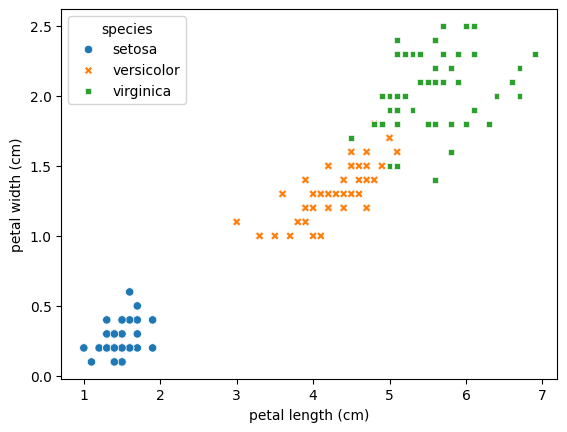

In [1]:
# Seaborn과 Matplotlib 라이브러리를 사용하기 위해 import 합니다.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # iris 데이터를 불러오기 위해 추가
from sklearn.datasets import load_iris # iris 데이터 로드를 위해 추가

# iris 데이터 로드
iris_data = load_iris()
iris_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris_df['species'] = iris_data.target
species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris_df['species'] = iris_df['species'].map(species_map)

# 붓꽃(iris) 데이터의 petal_length와 petal_width를 기준으로 산점도를 그립니다.
# hue와 style 옵션을 'species'로 지정하여 품종별로 색상과 모양을 다르게 표현합니다.
ax = sns.scatterplot(x="petal length (cm)", y="petal width (cm)",
                     hue="species", style="species", data=iris_df)
plt.show()

- **코드 해설**: Seaborn 라이브러리를 사용해 붓꽃 데이터의 분포를 시각화함. 세 품종이 비교적 명확하게 구분되는 것을 볼 수 있음. 이 그래프를 '이상적인 케이스'로 삼아, 이후의 어려운 데이터들에서 K-Means가 왜 실패하는지 비교하며 이해함.

### 1\) 군집의 크기(size)가 다를 경우

#### 데이터 생성

  - 데이터 포인트 개수가 현저하게 다른 세 개의 군집을 인위적으로 생성.

<!-- end list -->

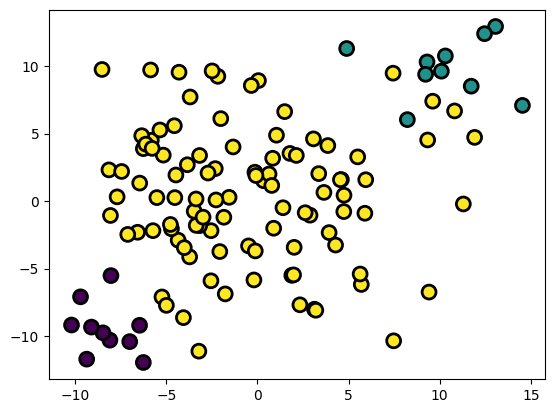

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 재현성을 위해 난수 시드 설정
np.random.seed(0)

# 첫 번째 군집: 평균 -10, 표준편차 2, 데이터 10개, 클래스 0
group0 = np.random.normal(-10, 2, (10, 2))
class0 = np.full(group0.shape[0], 0)
group0 = np.c_[group0, class0]

# 두 번째 군집: 평균 10, 표준편차 2, 데이터 10개, 클래스 1
group1 = np.random.normal(10, 2, (10, 2))
class1 = np.full(group1.shape[0], 1)
group1 = np.c_[group1, class1]

# 세 번째 군집: 평균 0, 표준편차 5, 데이터 100개, 클래스 2
group2 = np.random.normal(0, 5, (100, 2))
class2 = np.full(group2.shape[0], 2)
group2 = np.c_[group2, class2]

# 3개의 군집 데이터를 하나로 합침
data = np.r_[group0, group1, group2]

# 생성된 데이터의 산점도 시각화
plt.scatter(x=data[:, 0], y=data[:, 1],
            marker='o', c=data[:, 2].astype(int), s=100,
            edgecolor='k', linewidth=2)
plt.show()

- **코드 해설**: `np.random.normal`을 사용해 정규분포를 따르는 2차원 데이터를 생성함. `group0`와 `group1`은 10개, `group2`는 100개의 데이터를 가지도록 하여 군집 크기에 차이를 둠.

#### K-Means 적용 (k=3)

In [3]:
from sklearn.cluster import KMeans

# k=3으로 K-Means 모델 생성 및 학습
model = KMeans(n_clusters=3, init="random")
model.fit(data[:, 0:2]) # 클래스 정보를 제외한 좌표 데이터로 학습

KMeans(init='random', n_clusters=3)

In [4]:
# 군집 중심점 확인
model.cluster_centers_

array([[-3.13489417,  3.70267232],
       [ 7.98532306,  5.08814034],
       [-2.4365573 , -5.47610309]])

[2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 2 0 0 2 2 2 2 0 0 1 2
 2 2 0 0 2 1 1 0 0 0 0 0 0 1 0 0 2 1 1 0 0 1 1 2 0 0 0 1 0 0 0 2 2 0 0 1 0
 2 0 2 2 2 2 0 1 0 2 1 1 2 0 2 0 2 2 2 0 0 0 2 2 1 1 2 1 2 2 0 1 2 2 0 1 2
 0 0 0 2 2 0 0 2 0]


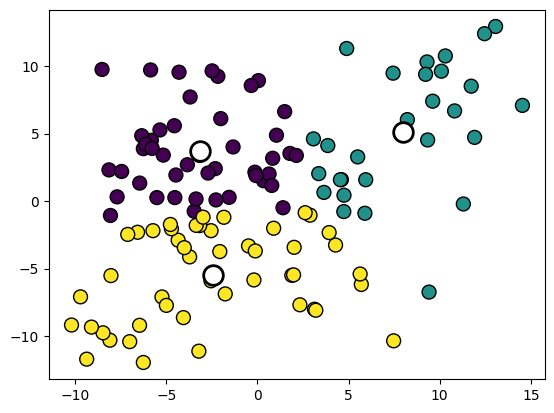

In [5]:
# 각 데이터 포인트의 군집 예측
pred = model.predict(data[:, 0:2])
print(pred)

# 군집 분석 결과 시각화
c = model.cluster_centers_

# 데이터 포인트를 예측된 군집(pred)에 따라 색칠
plt.scatter(x=data[:, 0], y=data[:, 1], c=pred,
            s=100, edgecolor="k", linewidth=1) # linewidth 수정

# 군집의 중심점을 흰색 큰 점으로 표시
plt.scatter(x=c[:, 0], y=c[:, 1], s=200, c='w', edgecolor='k', linewidth=2)
plt.show()

- **결과 해설**: K-Means 결과가 직관과 다르게 나타남. 데이터가 많은 중앙의 큰 그룹을 둘로 나누고, 별개였던 왼쪽 아래의 작은 그룹을 중앙 그룹의 일부와 합쳐버림. 이는 K-Means가 각 군집의 **크기(데이터 수)를 비슷하게 만들려는 경향** 때문에 발생함.

<!-- end list -->

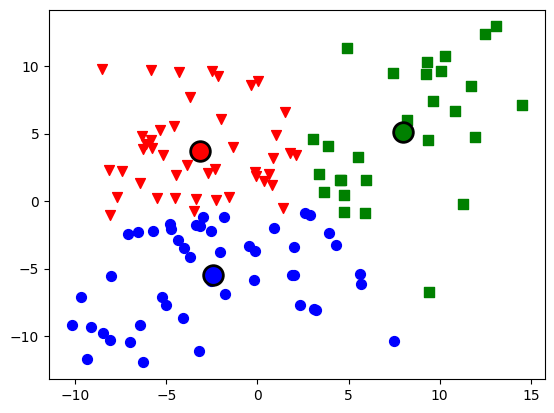

In [6]:
# 군집 중심점 분리
c0, c1, c2 = model.cluster_centers_

# 0번 군집 시각화
plt.scatter(x=data[model.labels_ == 0, 0], y=data[model.labels_ == 0, 1],
            s=50, marker='v', c='r')
# 1번 군집 시각화
plt.scatter(x=data[model.labels_ == 1, 0], y=data[model.labels_ == 1, 1],
            s=50, marker='s', c='g')
# 2번 군집 시각화
plt.scatter(x=data[model.labels_ == 2, 0], y=data[model.labels_ == 2, 1],
            s=50, marker='o', c='b')

# 각 군집의 중심점 시각화
plt.scatter(x=c0[0], y=c0[1], s=200, c='r', edgecolor='k', linewidth=2)
plt.scatter(x=c1[0], y=c1[1], s=200, c='g', edgecolor='k', linewidth=2)
plt.scatter(x=c2[0], y=c2[1], s=200, c='b', edgecolor='k', linewidth=2)
plt.show()

#### 해결 방안: 클러스터 수 `k` 늘리기

  - 하나의 큰 군집을 여러 개의 작은 군집으로 쪼개서 표현하기 위해 `k`를 더 크게 설정.

<!-- end list -->

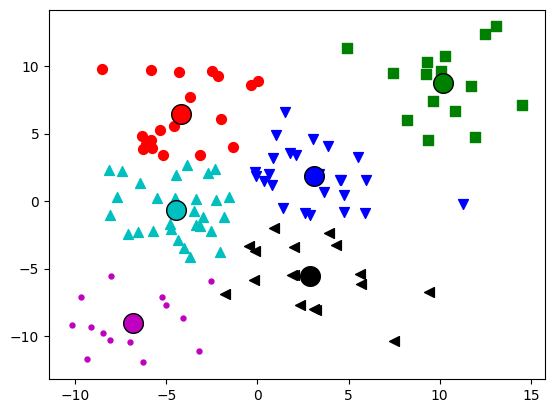

In [7]:
# k=6으로 K-Means 모델 생성 및 학습
model = KMeans(n_clusters=6, init="random")
model.fit(data[:, 0:2])

centers = model.cluster_centers_
colors = ['r', 'g', 'b', 'c', 'm', 'k']
markers = ['o', 's', 'v', '^', '.', '<']

# 반복문을 이용해 6개 군집 시각화
for i, c in enumerate(centers):
    # 각 군집별 데이터 시각화
    plt.scatter(x=data[model.labels_ == i, 0], y=data[model.labels_ == i, 1],
                s=50, marker=markers[i], c=colors[i])
    # 각 군집의 중심점 시각화
    plt.scatter(x=c[0], y=c[1], s=200, c=colors[i], edgecolor='k') # linewidth 파라미터 추가 가능

plt.show()

- **결과 해설**: `k`를 6으로 늘리자, 원래 의도했던 3개의 그룹이 시각적으로 더 잘 구분됨. 중앙의 큰 그룹은 4개의 작은 군집으로 나뉘었고, 분석가는 이를 하나의 그룹으로 다시 묶어 해석할 수 있음.

-----

### 2\) 군집의 밀도(density)가 다를 경우

#### 데이터 생성

  - 표준편차(`std`) 값을 다르게 하여 밀도가 다른 세 그룹을 생성.

<!-- end list -->

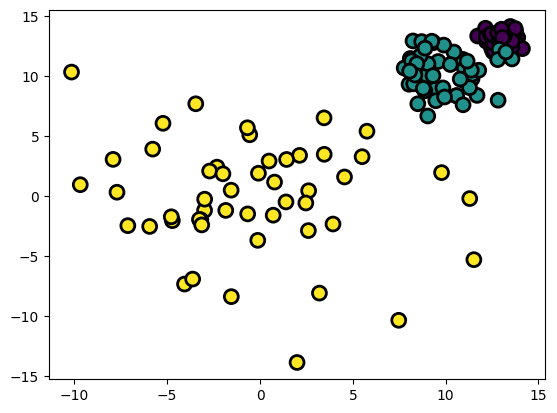

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# 첫 번째 군집: 평균 13, 표준편차 0.5 (고밀도), 50개
group0 = np.random.normal(13, 0.5, (50, 2))
class0 = np.full(group0.shape[0], 0)
group0 = np.c_[group0, class0]

# 두 번째 군집: 평균 10, 표준편차 1.5 (중밀도), 50개
group1 = np.random.normal(10, 1.5, (50, 2))
class1 = np.full(group1.shape[0], 1)
group1 = np.c_[group1, class1]

# 세 번째 군집: 평균 0, 표준편차 5 (저밀도), 50개
group2 = np.random.normal(0, 5, (50, 2))
class2 = np.full(group2.shape[0], 2)
group2 = np.c_[group2, class2]

# 데이터 합치기
data = np.r_[group0, group1, group2]

# 생성된 데이터 산점도 시각화
plt.scatter(x=data[:, 0], y=data[:, 1],
            marker='o', c=data[:, 2].astype(int), s=100,
            edgecolor='k', linewidth=2)
plt.show()

- **코드 해설**: 표준편차 0.5인 고밀도 군집, 1.5인 중간 밀도 군집, 5인 저밀도 군집이 생성됨.

#### K-Means 적용 (k=3)

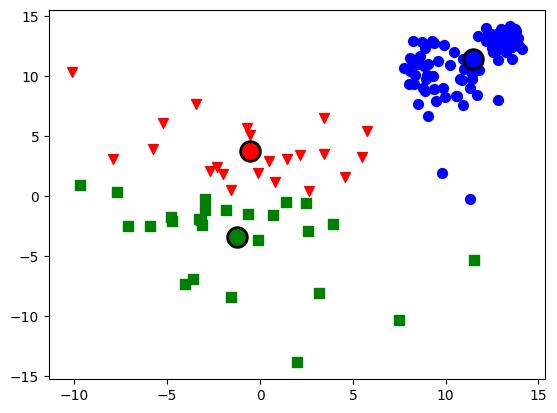

In [9]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, init="random")
model.fit(data[:, 0:2])

# 군집 분석 결과 시각화 (마커 구분)
c0, c1, c2 = model.cluster_centers_

plt.scatter(x=data[model.labels_ == 0, 0], y=data[model.labels_ == 0, 1], s=50, marker='v', c='r')
plt.scatter(x=data[model.labels_ == 1, 0], y=data[model.labels_ == 1, 1], s=50, marker='s', c='g')
plt.scatter(x=data[model.labels_ == 2, 0], y=data[model.labels_ == 2, 1], s=50, marker='o', c='b')

plt.scatter(x=c0[0], y=c0[1], s=200, c='r', edgecolor='k', linewidth=2)
plt.scatter(x=c1[0], y=c1[1], s=200, c='g', edgecolor='k', linewidth=2)
plt.scatter(x=c2[0], y=c2[1], s=200, c='b', edgecolor='k', linewidth=2)
plt.show()

- **결과 해설**: 이번에도 결과가 기대와 다름. 밀도가 높은 두 군집을 하나로 합치고, 밀도가 낮은 군집을 둘로 나눠버림. 이는 K-Means가 **데이터의 밀도를 고려하지 않고** 오직 중심점까지의 거리만을 기준으로 군집을 나누기 때문에 발생함.

#### 해결 방안: 클러스터 수 `k` 늘리기

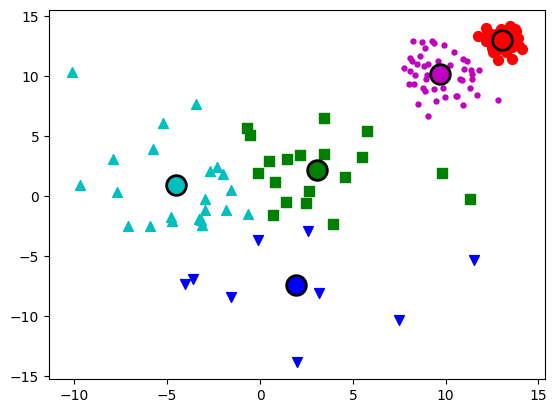

In [10]:
# k=5로 K-Means 모델 생성 및 학습
model = KMeans(n_clusters=5, init="random")
model.fit(data[:, 0:2])

centers = model.cluster_centers_
colors = ['r', 'g', 'b', 'c', 'm']
markers = ['o', 's', 'v', '^', '.']

# 반복문을 이용해 5개 군집 시각화
for i, c in enumerate(centers):
    plt.scatter(x=data[model.labels_ == i, 0], y=data[model.labels_ == i, 1],
                s=50, marker=markers[i], c=colors[i])
    plt.scatter(x=c[0], y=c[1], s=200, c=colors[i], edgecolor='k', linewidth=2)

plt.show()

- **결과 해설**: `k=5`로 설정하니, 밀도가 높았던 두 그룹이 명확히 분리되고, 저밀도 그룹은 3개의 작은 군집으로 나뉘어 전체적으로 원래 그룹 구조를 더 잘 반영하게 됨.

-----

### 3\) 비 구형(non-globular)인 경우

#### 데이터 생성

  - `sin`과 `cos` 함수를 이용해 초승달 모양의 데이터를 생성.

<!-- end list -->

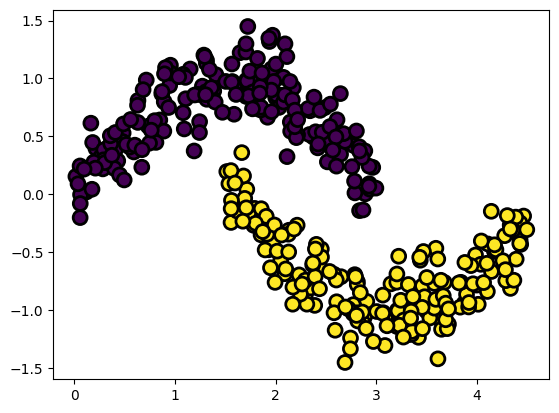

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# sin 함수를 기반으로 첫 번째 초승달 모양 데이터 생성
X1 = np.random.rand(200) * 3
noise = np.random.normal(0, 0.2, X1.shape)
Y1 = np.sin(X1) + noise
group1 = np.c_[X1, Y1, np.full(X1.shape[0], 0)]

# cos 함수를 기반으로 두 번째 초승달 모양 데이터 생성
X2 = X1 + 1.5
Y2 = np.cos(X2) + noise
group2 = np.c_[X2, Y2, np.full(X2.shape[0], 1)]

# 데이터 합치기
data = np.r_[group1, group2]

# 생성된 데이터 산점도 시각화
plt.scatter(x=data[:, 0], y=data[:, 1], marker='o',
            c=data[:, 2].astype(int), s=100,
            edgecolor='k', linewidth=2)
plt.show()

- **코드 해설**: `sin` 곡선과 `cos` 곡선을 따라 분포하는 두 개의 초승달 모양 군집이 생성됨.

#### K-Means 적용 (k=2)

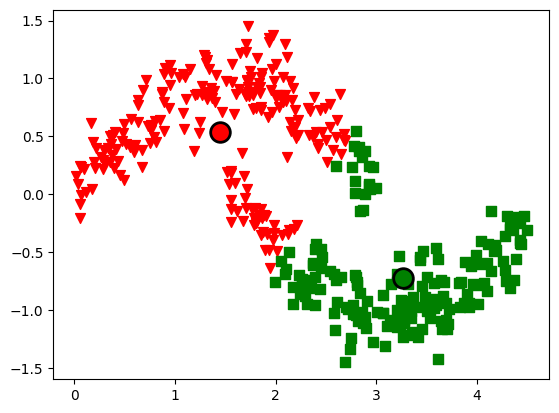

In [12]:
from sklearn.cluster import KMeans

# k=2로 K-Means 모델 생성 및 학습
model = KMeans(n_clusters=2, init="random")
model.fit(data[:, 0:2])

# 군집 분석 결과 시각화 (마커 구분)
c0, c1 = model.cluster_centers_

plt.scatter(x=data[model.labels_ == 0, 0], y=data[model.labels_ == 0, 1], s=50, marker='v', c='r')
plt.scatter(x=data[model.labels_ == 1, 0], y=data[model.labels_ == 1, 1], s=50, marker='s', c='g')

plt.scatter(x=c0[0], y=c0[1], s=200, c='r', edgecolor='k', linewidth=2)
plt.scatter(x=c1[0], y=c1[1], s=200, c='g', edgecolor='k', linewidth=2)
plt.show()

- **결과 해설**: 완전히 잘못된 결과임. K-Means는 초승달 모양을 인식하지 못하고, 단순히 데이터를 수직으로 잘라 두 개의 덩어리로 나눔. 이는 K-Means가 **군집의 형태가 아닌 중심점에서의 거리만 고려**하기 때문에 발생하는 전형적인 한계임.

#### 해결 방안: 클러스터 수 `k` 늘리기와 실루엣 계수

  - `k`를 7로 늘려 해결을 시도.

<!-- end list -->

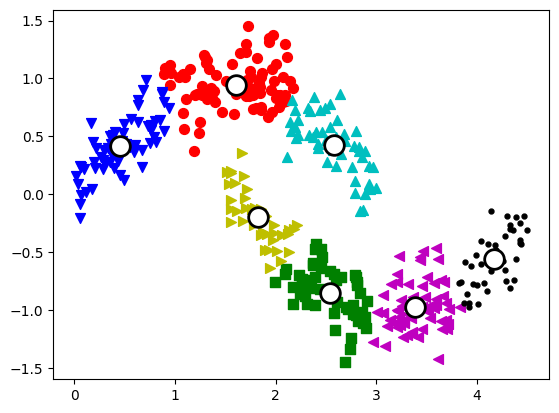

In [13]:
# k=7, random_state=2로 모델 생성 및 학습
model = KMeans(n_clusters=7, init="random", random_state=2)
model.fit(data[:, 0:2])

center = model.cluster_centers_
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
markers = ['o', 's', 'v', '^', '<', '>', '.'] # 마커 개수 7개로 수정

# 반복문을 이용해 7개 군집 시각화
for i, c in enumerate(center):
    plt.scatter(x=data[model.labels_ == i, 0], y=data[model.labels_ == i, 1],
                s=50, marker=markers[i], c=colors[i]) # c=colors[i]로 수정
    # 중심점을 흰색으로 표시
    plt.scatter(x=c[0], y=c[1], s=200, c='w', edgecolor='k', linewidth=2) # linewidth=2로 수정

plt.show()

- **결과 해설**: `k`를 7로 늘리니, 각 초승달 모양을 여러 개의 작은 구형 군집으로 나누어 그 형태를 **근사하게 따라가는 것**을 볼 수 있음.

  - **`실루엣 계수(Silhouette Score)`**: 군집이 얼마나 잘 형성되었는지를 평가하는 정량적 지표. 1에 가까울수록 좋음.

<!-- end list -->

In [14]:
from sklearn.metrics import silhouette_score

# 테스트할 k의 범위
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # k값에 따라 모델 생성 및 예측
    model = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = model.fit_predict(data[:, :-1]) # 마지막 열(정답 클래스) 제외

    # 실루엣 계수 계산
    score = silhouette_score(data[:, :-1], cluster_labels)
    print("클러스터 수: {}, 실루엣 계수: {}".format(n_clusters, score))

클러스터 수: 2, 실루엣 계수: 0.531719027056325
클러스터 수: 3, 실루엣 계수: 0.46877239572522744
클러스터 수: 4, 실루엣 계수: 0.47459404347982115
클러스터 수: 5, 실루엣 계수: 0.48842930106655835
클러스터 수: 6, 실루엣 계수: 0.4989572020024638
클러스터 수: 7, 실루엣 계수: 0.5038738136688508
클러스터 수: 8, 실루엣 계수: 0.4582187683308574
클러스터 수: 9, 실루엣 계수: 0.46315528249774246
클러스터 수: 10, 실루엣 계수: 0.4399245964414895


- **결과 해설**: 흥미롭게도 \*\*`실루엣 계수`\*\*가 가장 높은 것은 `k=2`일 때이지만, 시각적으로는 최악의 결과임. 이는 실루엣 계수 역시 완벽한 지표는 아니며, 특히 **비 구형 데이터에서는 잘못된 판단**을 내릴 수 있음을 보여줌. 따라서 항상 시각화와 정량적 지표를 함께 고려하여 최적의 `k`를 판단해야 함.

-----

## 4\. 핵심 요약 (Key Takeaways)

  - **비즈니스 관점**: 고객 데이터가 항상 깔끔한 원형 군집을 이루리라 가정해서는 안 됨. K-Means 결과를 맹신하지 말고, 반드시 **시각화**를 통해 군집이 상식적으로 잘 형성되었는지 확인해야 함.
  - **기술 관점 (한계)**: K-Means는 본질적으로 군집이 **(1)구형이고, (2)크기와 밀도가 비슷할 때** 가장 잘 작동함. 데이터가 이 가정을 벗어나는 **`크기`**, **`밀도`**, **`비 구형`** 문제를 가질 때 성능이 급격히 저하될 수 있음.
  - **기술 관점 (극복)**: K-Means의 한계를 극복하는 실용적인 방법 중 하나는 의도적으로 **`k`의 개수를 늘려(over-clustering)**, 하나의 복잡한 군집을 여러 개의 단순한 군집의 조합으로 표현하는 것임. 이때 \*\*`실루엣 계수`\*\*를 참고할 수 있지만, 최종 판단은 반드시 **시각화 결과**와 함께 내려야 함.